<a href="https://colab.research.google.com/github/respect5716/Deep_Learning_Paper_Implementation/blob/main/02_Vision/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

## 0. Paper

### Info
* Title: Unsupervised Representation Learning with Deep Convolutional Adversarial Networks
* Author: Alec Radford
* Task: Image Generation
* Link: https://arxiv.org/abs/1511.06434


### Features
* Dataset: celeba, [link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

### Reference
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


## 1. Setting

In [ ]:
!pip install -q wandb
!pip install -q pytorch_lightning

In [1]:
import os
import wandb
import easydict
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl

In [2]:
pl.utilities.seed.seed_everything(999)

Global seed set to 999


999

In [3]:
args = easydict.EasyDict({
    'lr': 2e-4,
    'beta1': 0.5,
    'beta2': 0.999,
    'latent_dim': 100,
    'gen_dim': 64,
    'dis_dim': 64,
    'image_size': 64,
    'batch_size': 128,
    'epoch_size': 5,
    'device': 'cuda' if torch.cuda.is_available else 'cpu',
    'base_dir': '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation'
})

## 2. Data

In [6]:
dataset = 'celeba'
data_path = os.path.join(args.base_dir, f'data/{dataset}.zip')
!unzip -q "{data_path}" -d 'data'

In [4]:
transform = transforms.Compose([
    transforms.Resize(args.image_size),
    transforms.CenterCrop(args.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
dataset = torchvision.datasets.ImageFolder(
    root = '/content/data',
    transform = transform
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

data = next(iter(dataloader))
data[0].size()

torch.Size([128, 3, 64, 64])

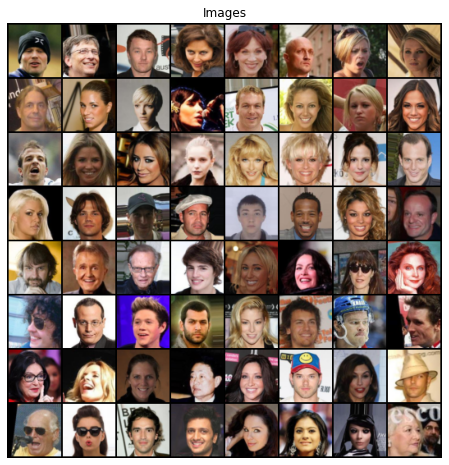

In [6]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Images')
plt.imshow(torchvision.utils.make_grid(data[0][:64], padding=2, normalize=True).permute(1, 2, 0))
plt.show()

## 3. Model

In [8]:
activations = {
    'relu': nn.ReLU(),
    'tanh': nn.Tanh(),
    'leaky': nn.LeakyReLU(0.2),
    'sigmoid': nn.Sigmoid()
}

def initialize(m:nn.Module):
    cls_name = m.__class__.__name__
    if 'Block' in cls_name:
        pass
    elif 'Conv' in cls_name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in cls_name:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class ConvBlock(nn.Module):
    def __init__(self, in_C, out_C, ks, st, pd, actv, bn, transpose):
        super(ConvBlock, self).__init__()
        if transpose:
            self.conv = nn.ConvTranspose2d(in_C, out_C, ks, st, pd, bias=not bn)
        else:
            self.conv = nn.Conv2d(in_C, out_C, ks, st, pd, bias=not bn)
        self.actv = activations[actv]
        self.bn = nn.BatchNorm2d(out_C) if bn else None

    def forward(self, x):
        x = self.conv(x)
        x = self.actv(x)
        x = self.bn(x) if self.bn is not None else x
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        self.block1 = ConvBlock(args.latent_dim, args.gen_dim*8, 4, 1, 0, 'relu', bn=True, transpose=True)
        self.block2 = ConvBlock(args.gen_dim*8, args.gen_dim*4, 4, 2, 1, 'relu', bn=True, transpose=True)
        self.block3 = ConvBlock(args.gen_dim*4, args.gen_dim*2, 4, 2, 1, 'relu', bn=True, transpose=True)
        self.block4 = ConvBlock(args.gen_dim*2, args.gen_dim, 4, 2, 1, 'relu', bn=True, transpose=True)
        self.block5 = ConvBlock(args.gen_dim, 3, 4, 2, 1, 'tanh', bn=False, transpose=True)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.block1 = ConvBlock(3, args.dis_dim, 4, 2, 1, 'leaky', bn=False, transpose=False)
        self.block2 = ConvBlock(args.dis_dim, args.dis_dim*2, 4, 2, 1, 'leaky', bn=True, transpose=False)
        self.block3 = ConvBlock(args.dis_dim*2, args.dis_dim*4, 4, 2, 1, 'leaky', bn=True, transpose=False)
        self.block4 = ConvBlock(args.dis_dim*4, args.dis_dim*8, 4, 2, 1, 'leaky', bn=True, transpose=False)
        self.block5 = ConvBlock(args.dis_dim*8, 1, 4, 1, 0, 'sigmoid', bn=False, transpose=False)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x

In [32]:
class GAN(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.criterion = nn.BCELoss()

        self.g = Generator(self.hparams)
        self.g.apply(initialize)
        self.d = Discriminator(self.hparams)
        self.d.apply(initialize)
        self.z = torch.rand(64, self.hparams.latent_dim, 1, 1)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.g.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, self.hparams.beta2))
        opt_d = torch.optim.Adam(self.d.parameters(), lr=self.hparams.lr / 2, betas=(self.hparams.beta1, self.hparams.beta2))
        return opt_d, opt_g

    def forward(self, z):
        return self.g(z)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real, _ = batch
        batch_size = real.size(0)
        real_label = torch.ones((batch_size,), device=self.device)
        fake_label = torch.zeros((batch_size,), device=self.device)
        z = torch.rand(batch_size, self.hparams.latent_dim, 1, 1, device=self.device)

        # dis step
        if optimizer_idx == 0:
            fake = self.g(z).detach()
            outputs = self.d(real).view(-1)
            real_loss = self.criterion(outputs, real_label)
            outputs = self.d(fake).view(-1)
            fake_loss = self.criterion(outputs, fake_label)
            d_loss = real_loss + fake_loss

            self.log_dict({'d_loss':d_loss, 'd_real_loss':real_loss, 'd_fake_loss':fake_loss})
            return d_loss
        
        # gen step
        if optimizer_idx == 1:
            fake = self.g(z)
            outputs = self.d(fake).view(-1)
            g_loss = self.criterion(outputs, real_label)
            self.log_dict({'g_loss': g_loss})
            return g_loss

    def generate(self):
        fake = self.g(self.z.to(self.device)).detach().cpu()
        img = torchvision.utils.make_grid(fake, padding=2, normalize=True).permute(1, 2, 0).numpy()
        return img

    def on_epoch_end(self):
        img = self.generate()
        self.logger.experiment.log({f'fake_{self.trainer.current_epoch}': wandb.Image(img)})

## 4. Train

In [33]:
gan = GAN(**args)

In [34]:
logger = pl.loggers.WandbLogger(
    project = 'paper',
    reinit = True,
    log_model = False
)

logger.watch(gan)

In [35]:
trainer = pl.Trainer(
    gpus = -1,
    max_epochs = args.epoch_size,
    logger = logger,
    log_every_n_steps = 10,
    #fast_dev_run = True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [36]:
trainer.fit(gan, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | criterion | BCELoss       | 0     
1 | g         | Generator     | 3.6 M 
2 | d         | Discriminator | 2.8 M 
--------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)


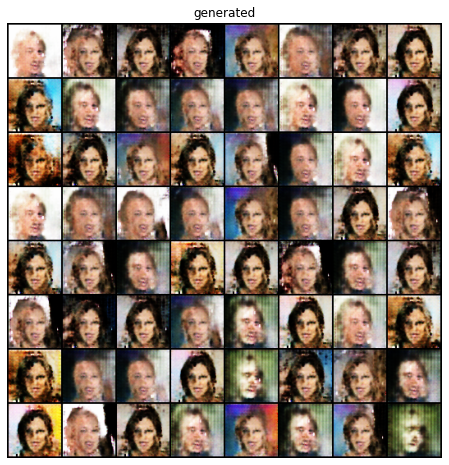

In [37]:
img = gan.generate()
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('generated')
plt.imshow(img)
plt.show()

In [38]:
wandb.run.finish()

d_loss,0.31578
d_real_loss,0.31231
d_fake_loss,0.00347
g_loss,6.34282
epoch,4
trainer/global_step,7909
_runtime,2086
_timestamp,1626825995
_step,795


d_loss,▂▂▁▂▁▁▁▄▁▃▃▂▂▂▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁█▂▂
d_real_loss,▂▁▁▁▁▁▁▄▁▃▁▁▂▁▁▁▂▂▁▂▂▂▂▁▂▁▂▂▂▁▁▁▃▁▁▁▁█▂▃
d_fake_loss,▁▃▁▂▂▁▁▃▂▂█▄▂▂▆▂▄▃▆▅▂▂▂▅▂▂▂▂▁▃▂▅▃▂▂▃▂▁▂▁
g_loss,▇▇█▅▆▅▄▃▄▃█▄▄▄▃▃▂▃▄▃▃▃▃▅▃▄▄▃▃▃▄▅▂▃▃▃▃▁▂▃
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
